In [1]:
import util
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it

from IPython.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

font = {
    'family':'serif', 
    'weight':'normal', 
    'size':12
}

plt.rc('font', **font)

In [2]:
pallete = sns.color_palette("Set1", 20)
plot_dict = {
    'GreedyKS': (pallete[0], 'P'),
    'IKS + RS': (pallete[2], 'X'),
    'Lall + DDSketch': (pallete[3], 'o'),
    'Reservoir Sampling': (pallete[1], 's'),
}

In [3]:
ts_all = util.load_call_center_data()
ts_first_week = next(iter(ts_all.groupby([ts_all.dt.isocalendar().week])))[1]
ts_from_first_workhour = ts_first_week[np.where(ts_first_week.dt.hour == 8)[0][0]:]
td_from_first_workhour = (ts_from_first_workhour[1:].values - ts_from_first_workhour[:-1].values).astype(float)/10**9

In [4]:
ts_first_workhour = next(iter(ts_from_first_workhour.groupby([
    ts_from_first_workhour.dt.year,
    ts_from_first_workhour.dt.month,
    ts_from_first_workhour.dt.day,
    ts_from_first_workhour.dt.hour])))[1]

td_first_workhour = (ts_first_workhour[1:].values - ts_first_workhour[:-1].values).astype(float)/10**9

ref_distrib = st.expon(*st.expon.fit(td_first_workhour))

In [5]:
while True:
    eff_results = util.eval_effectiveness(
        ref_distrib,
        td_from_first_workhour,
        int(10**2),
        len(td_first_workhour)
    )
    
    if not np.isnan(list(eff_results.values())).any():
        break

    print('again')

eff_results_exact_ks = eff_results['Exact KS']

del eff_results['Exact KS']

eff_results_exact_ks, eff_results

(1638,
 {'Reservoir Sampling': 4289,
  'GreedyKS': 1638,
  'Lall + DDSketch': 514,
  'IKS + RS': 6901})

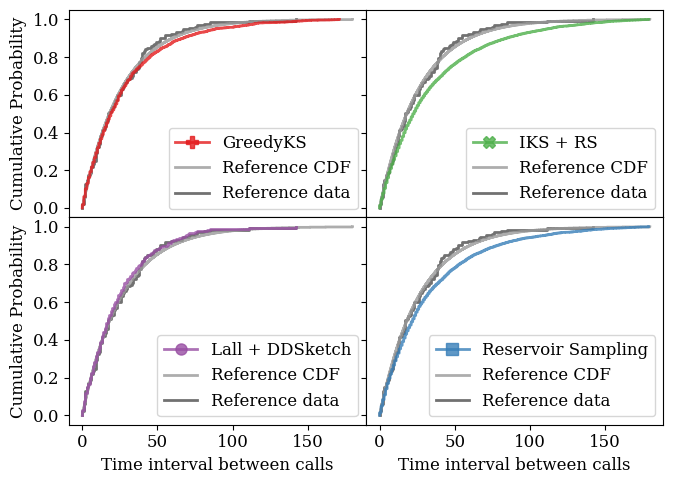

In [89]:
data = {'Reference CDF': ref_distrib.ppf(np.linspace(0,1,10**3)[:-1])}
data['Reference data'] = td_first_workhour[td_first_workhour <= data['Reference CDF'][-1]]

fig, axs = plt.subplots(2, 2, sharey=True, figsize=(7,5),  gridspec_kw={'hspace':0.0, 'wspace':0.0})

for ax, method in zip(axs.flat, sorted(eff_results)):
    method_data = td_from_first_workhour[:eff_results[method]]
    method_data = method_data[method_data <= data['Reference CDF'][-1]]
    
    data[method] = method_data
    
    data = {k: data[k] for k in [method, 'Reference CDF', 'Reference data']}
    
    plt.sca(ax)
    sns.ecdfplot(data, palette=[plot_dict[method][0], [0.6]*3, [0.3]*3], lw=2, alpha=0.8)
    ax.legend_.legendHandles[0].set_marker(plot_dict[method][1])
    ax.legend_.legendHandles[0].set_markersize(8)
    plt.ylabel('Cumulative Probability')
    plt.xlabel('Time interval between calls')
    plt.ylim((-.05, 1.05))
    
plt.tight_layout()
fig.savefig('./data_pdf_files/call_center_gof.pdf')

In [90]:
stats = {}
for method in sorted(eff_results):
    stats.setdefault('Drift Point', {})[method] = ts_from_first_workhour.iloc[eff_results[method]]
    stats.setdefault('D statistic', {})[method] = st.ks_1samp(td_from_first_workhour[:eff_results[method]], ref_distrib.cdf)[0]
    #stats.setdefault('D statistic TS', {})[method] = st.ks_2samp(td_from_first_workhour[:eff_results[method]], td_first_workhour)[0]
    
stats = pd.DataFrame(stats)
stats.rename_axis(index='Methods', inplace=True)
stats.columns = pd.MultiIndex.from_tuples([('Results', i) for i in stats.columns])

stats.style.to_latex(
    './data_pdf_files/call_center_gof.tex',
    position='h',
    position_float='centering',
    hrules=True,
    label='tab:call_center_gof',
    caption='''
        Results of the experiment of drift detection of call records starting from 8:00 of 1999-01-04.
        The value of the $D$ statistic considered a reference Exponential distribution fitted to first hour subsample and all data up to the detected drift point.
    ''',
    multicol_align='c',
)
stats

Results            
                           Drift Point D statistic
Methods                                           
GreedyKS           1999-01-04 21:41:26    0.039804
IKS + RS           1999-01-09 18:31:35    0.118255
Lall + DDSketch    1999-01-04 11:40:41    0.040808
Reservoir Sampling 1999-01-06 16:08:55    0.094218

In [91]:
hour_count = ts_from_first_workhour.groupby([
    ts_from_first_workhour.dt.year,
    ts_from_first_workhour.dt.month,
    ts_from_first_workhour.dt.day,
    ts_from_first_workhour.dt.hour]).size().values

In [92]:
for i in np.cumsum(hour_count)-1:
    if st.ks_1samp(td_from_first_workhour[:i], ref_distrib.cdf).pvalue < 0.01:
        print(ts_from_first_workhour.iloc[i])
        break

1999-01-04 21:59:47
